In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchsummary import summary

### Dataset Loading

In [59]:
import json, gzip

class MNIST_Dataset(Dataset):
    def __init__(self, json_data) -> None:
        self.features = [torch.FloatTensor(i['image']).view(28,28) for i in json_data]
        self.labels = [torch.LongTensor([i['label']]) for i in json_data]
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = None
dev_dataset = None
test_dataset = None

with gzip.open('mnist_rowmajor.jsonl.gz') as file:
    trainval_data = []
    test_data = []

    for sample in [json.loads(line) for line in file]:
        sample['image'] = sample['image']
        if sample['split'] == 'train':
            trainval_data.append(sample)
        else:
            test_data.append(sample)

    train_dataset = MNIST_Dataset(trainval_data[:50000])
    dev_dataset = MNIST_Dataset(trainval_data[50000:])
    test_dataset = MNIST_Dataset(test_data)

In [60]:
BATCH_SIZE = 64

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

### Question 2b - models

In [61]:
class LinearAutoEncoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 10)
        )
        self.decoder = nn.Sequential(
            nn.Linear(10, 50),
            nn.ReLU(),
            nn.Linear(50, 100),
            nn.ReLU(),
            nn.Linear(100, 28*28),
            nn.Sigmoid()
        )

    def encode(self, x):
        z = self.encoder(x)
        return z
    
    def decode(self, z):
        pred_x = self.decoder(z)
        return pred_x
    
    def forward(self, x, detach = False):
        pred_x = self.decode(self.encode(x.view(-1,28*28)))
        if detach:
            pred_x = pred_x.cpu().detach()
        return pred_x.view(-1,28,28)

In [68]:
class ConvAutoEncoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.encoder = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(1, 5, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(5, 10, kernel_size=4, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1000, 10)
        )
        self.decoder = nn.Sequential(
            nn.Linear(10, 1000),
            nn.Unflatten(1, (10,10,10)),
            nn.ReLU(),
            nn.ConvTranspose2d(10, 5, kernel_size=4, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(5, 1, kernel_size=4, stride=2),
            nn.Sigmoid()
        )

    def encode(self, x):
        z = self.encoder(x)
        return z
    
    def decode(self, z):
        pred_x = self.decoder(z)
        return pred_x
    
    def forward(self, x, detach = False):
        pred_x = self.decode(self.encode(x.view(-1,1,28,28)))
        if detach:
            pred_x = pred_x.cpu().detach()
        return pred_x.view(-1,28,28)

### Question 2b - Training

In [63]:
def eval(model: nn.Module, dataloader: DataLoader, criterion: nn.Module):
    # statistics
    total_loss = 0
    total_num = 0
    # dataset loop
    for x, _ in dataloader:
        # forward pass
        x_pred = model.forward(x, detach=True)
        # update statistics
        total_loss += criterion(x_pred, x)
        total_num += x.shape[0]
    # ret
    return total_loss/total_num

In [64]:
def train(model: nn.Module, criterion: nn.Module, optimizer: optim.Optimizer, num_epoch = 1, in_dim = (1)):
    print(f'{"":<10} {"Train":^10} {"Dev":^10}')
    # epoch loop
    for epoch in range(num_epoch):
        # statistics
        total_loss = 0
        total_num = 0
        # dataset loop
        for x, _ in train_dataloader:
            # forward pass
            x_pred = model.forward(x)
            # calculate gradients
            loss = criterion(x_pred, x)
            loss.backward()
            # update statistics
            total_loss += criterion(x_pred, x)
            total_num += x.shape[0]
            # backward pass
            optimizer.step()
            optimizer.zero_grad()
        # output
        train_loss = total_loss/total_num
        dev_loss = eval(model, dev_dataloader, criterion)
        print(f'{f"Epoch {epoch+1}":<10} {train_loss:^10.5f} {dev_loss:^10.5f}')

In [65]:
linear_model = LinearAutoEncoder()
train(linear_model, nn.BCELoss(), optim.Adam(linear_model.parameters(), lr=0.005), 5)

             Train       Dev    


KeyboardInterrupt: 

In [69]:
conv_model = ConvAutoEncoder()
train(conv_model, nn.BCELoss(), optim.Adam(conv_model.parameters(), lr=0.005), 5)

             Train       Dev    


KeyboardInterrupt: 

### Dis

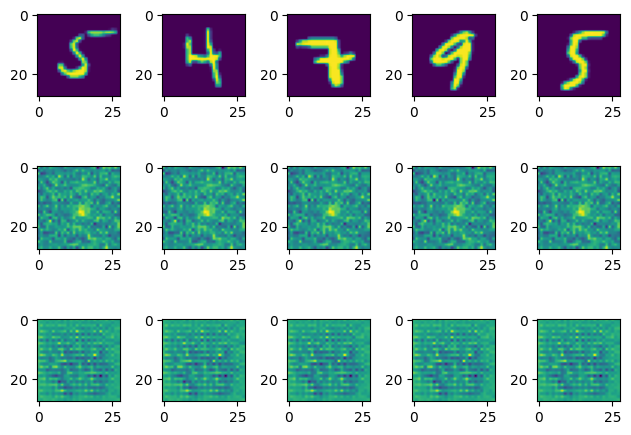

In [75]:
import random
fig, (row1, row2, row3) = plt.subplots(3, 5)

for i in range(5):
    x = dev_dataset[random.randint(0,10000)][0]
    x_pred_linear = linear_model.forward(x, detach=True).view(28,28)
    x_pred_conv = conv_model.forward(x, detach=True).view(28,28)

    row1[i].imshow(x)
    row2[i].imshow(x_pred_linear)
    row3[i].imshow(x_pred_conv)

plt.tight_layout()
plt.show()